In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats
%pylab inline
pl.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('Databases/Pollution/Main2015.csv')

In [3]:
# data.info()

In [4]:
print np.size(data['City Name'].unique())

961


There are 961 unique cities in the dataset, several of them have more than one pollution observation.

In [5]:
data['Pollutant Standard'].value_counts()[:10]

PM25 Annual 2006           993
PM25 Annual 2013           993
PM25 24-hour 2013          993
PM25 24-hour 2006          993
PM10 24-hour 2006          708
Ozone 8-Hour 1997          606
Ozone 8-Hour 2008          606
Ozone 1-hour Daily 2005    606
SO2 3-hour 1971            378
SO2 1-hour 2010            378
dtype: int64

Use PM 2.5 Annual 2013 since these particles are created by different types of emissions and are due to its size, a major concern for human health.

In [6]:
overview = data[['Latitude','Longitude','Parameter Name','Sample Duration','Pollutant Standard','Method Name','Units of Measure',
                 'Arithmetic Mean','Local Site Name','State Name','City Name','State Name']]
overview = overview[overview['Pollutant Standard']=='PM25 Annual 2013']
overview = overview.dropna()

In [7]:
pivot = overview.groupby('City Name')
# print pivot['Arithmetic Mean'].mean()

In [8]:
# reset_index transforms series into dataframe. allows for mergers later on.

# Get mean columns
pm_mean = pivot['Arithmetic Mean'].apply(np.mean).reset_index()

# Get sample duration mode
sam_mode = pivot['Sample Duration'].apply(stats.mode).reset_index()
# print sam_mode

# Get number of observation
num_obs = pivot['Sample Duration'].apply(np.count_nonzero).reset_index()
num_obs = num_obs.rename(columns={'Sample Duration':'Observatories Count'})
# print num_obs
# Check if count worked, Birmingham has six observations
# birm = overview[overview['City Name']=='Birmingham'].apply(np.count_nonzero)
# print birm

# Get mode of measurement units
uni_mode = pivot['Units of Measure'].apply(stats.mode).reset_index()
for i in uni_mode['Units of Measure']:
    uni_mode['MeasureUnits'] = uni_mode['Units of Measure'].apply(lambda x: x[0])
# print uni_mode

# Get mode of method name
meth_mode = pivot['Method Name'].apply(stats.mode).reset_index()
# print meth_mode

# Get aggregate of longitude/latitude
lat = pivot['Latitude'].apply(stats.mode).reset_index()
lon = pivot['Longitude'].apply(stats.mode).reset_index()
# print lat, lon

# Get state info
state = pivot['State Name'].apply(stats.mode).reset_index()
for i in state['State Name']:
    state['StateName'] = state['State Name'].apply(lambda x: x[0][0][0]) 

In [9]:
# Merge all
p1 = pd.merge(pm_mean, sam_mode, on='City Name', how='inner')
p2 = p1.merge(num_obs, on='City Name', how='inner')
p3 = p2.merge(uni_mode, on='City Name', how='inner')
p4 = p3.merge(meth_mode, on='City Name', how='inner')
p5 = p4.merge(lat, on='City Name', how='inner')
p6 = p5.merge(lon, on='City Name', how='inner')
pivot_final = p6.merge(state, on='City Name', how='inner')
pivot_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 371
Data columns (total 11 columns):
City Name              372 non-null object
Arithmetic Mean        372 non-null float64
Sample Duration        372 non-null object
Observatories Count    372 non-null int64
Units of Measure       372 non-null object
MeasureUnits           372 non-null object
Method Name            372 non-null object
Latitude               372 non-null object
Longitude              372 non-null object
State Name             372 non-null object
StateName              372 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 34.9+ KB


In [10]:
for i in pivot_final['Method Name']:
    pivot_final['MethodName'] = pivot_final['Method Name'].apply(lambda x: x[0])    
for i in pivot_final['Latitude']:
    pivot_final['Lat']= pivot_final['Latitude'].apply(lambda x: x[0])   
for i in pivot_final['Longitude']:
    pivot_final['Long'] = pivot_final['Longitude'].apply(lambda x: x[0])
for i in pivot_final['Sample Duration']:
    pivot_final['SampleDuration'] = pivot_final['Sample Duration'].apply(lambda x: x[0])    

In [11]:
pivot_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 371
Data columns (total 15 columns):
City Name              372 non-null object
Arithmetic Mean        372 non-null float64
Sample Duration        372 non-null object
Observatories Count    372 non-null int64
Units of Measure       372 non-null object
MeasureUnits           372 non-null object
Method Name            372 non-null object
Latitude               372 non-null object
Longitude              372 non-null object
State Name             372 non-null object
StateName              372 non-null object
MethodName             372 non-null object
Lat                    372 non-null object
Long                   372 non-null object
SampleDuration         372 non-null object
dtypes: float64(1), int64(1), object(13)
memory usage: 46.5+ KB


In [12]:
pivot_final.drop(['Sample Duration','State Name','Longitude','Method Name','Units of Measure','Latitude'], axis=1)
pivot_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 371
Data columns (total 15 columns):
City Name              372 non-null object
Arithmetic Mean        372 non-null float64
Sample Duration        372 non-null object
Observatories Count    372 non-null int64
Units of Measure       372 non-null object
MeasureUnits           372 non-null object
Method Name            372 non-null object
Latitude               372 non-null object
Longitude              372 non-null object
State Name             372 non-null object
StateName              372 non-null object
MethodName             372 non-null object
Lat                    372 non-null object
Long                   372 non-null object
SampleDuration         372 non-null object
dtypes: float64(1), int64(1), object(13)
memory usage: 46.5+ KB


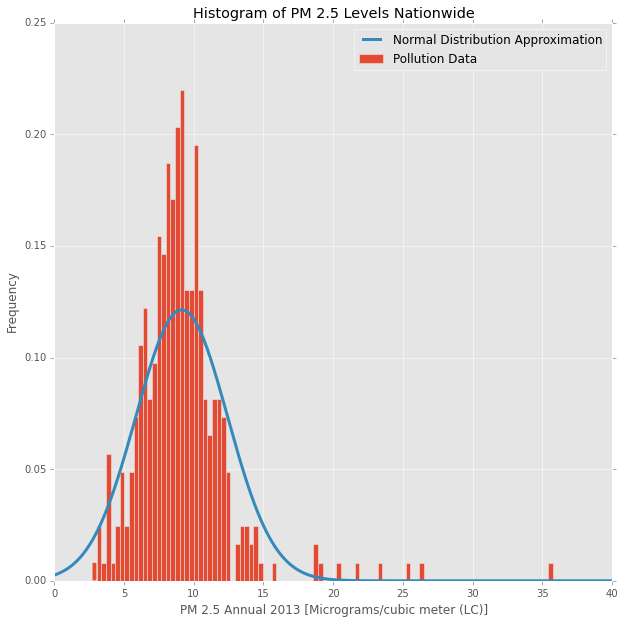

In [13]:
pl.figure(figsize=(10,10))
m, sd = stats.norm.fit(pivot_final['Arithmetic Mean'])
x = np.linspace(0,40,1000)
y = stats.norm.pdf(x, m, sd)

bins, hist, patches = pl.hist(pivot_final['Arithmetic Mean'], bins=100, normed=True, label='Pollution Data')
pl.plot(x,y, linewidth=3, label='Normal Distribution Approximation')
pl.xlabel('PM 2.5 Annual 2013 [Micrograms/cubic meter (LC)]')
pl.ylabel('Frequency')
pl.title('Histogram of PM 2.5 Levels Nationwide')
pl.legend()

Helpful links:

http://www3.epa.gov/airtrends/links.html

Map:

http://www3.epa.gov/airtrends/pm.html

Info:

http://www3.epa.gov/pm/

Data:

http://www3.epa.gov/airdata/ad_data.html

Real Time Data, API:

https://docs.airnowapi.org

# 2010 Dataset

In [14]:
data2010 = pd.read_csv('Databases/Pollution/Main2010.csv')

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [15]:
# data2010.info()

In [16]:
# More cities
print np.size(data2010['City Name'].unique())

1316


In [17]:
data2010['Pollutant Standard'].value_counts()[:10]

PM25 24-hour 2006          1423
PM25 Annual 2006           1423
PM25 Annual 2013           1419
PM25 24-hour 2013          1419
Ozone 8-Hour 1997          1356
Ozone 8-Hour 2008          1356
Ozone 1-hour Daily 2005    1356
PM10 24-hour 2006          1185
SO2 24-hour 1971            484
SO2 1-hour 2010             484
dtype: int64

Don't know why there exists annual data for 2013 when dataset is called all_2010. But choose 2013 because otherwise we cannot use census data from 2010.

In [18]:
oview = data2010[['County Code','Latitude','Longitude','Parameter Name','Sample Duration','Pollutant Standard','Method Name','Units of Measure',
                 'Arithmetic Mean','Local Site Name','State Name','City Name','State Name','CBSA Name']]
oview = oview[oview['Pollutant Standard']=='PM25 Annual 2013']
#oview = oview.dropna()

In [19]:
pivot2010 = oview.groupby('City Name')
#print pivot2010['Arithmetic Mean'].mean()

In [20]:
# reset_index transforms series into dataframe. allows for mergers later on.

# Get mean columns
pm_mean = pivot2010['Arithmetic Mean'].apply(np.mean).reset_index()
# print pm_mean

# Get sample duration mode
sam_mode = pivot2010['Sample Duration'].apply(stats.mode).reset_index()
# print sam_mode

# Get number of observation
num_obs = pivot2010['Sample Duration'].apply(np.count_nonzero).reset_index()
num_obs = num_obs.rename(columns={'Sample Duration':'Observatories Count'})
# print num_obs
# Check if count worked, Birmingham has six observations
# birm = overview[overview['City Name']=='Birmingham'].apply(np.count_nonzero)
# print birm

# Get mode of measurement units
uni_mode = pivot2010['Units of Measure'].apply(stats.mode).reset_index()
for i in uni_mode['Units of Measure']:
    uni_mode['MeasureUnits'] = uni_mode['Units of Measure'].apply(lambda x: x[0])
# print uni_mode

# Get mode of method name
meth_mode = pivot2010['Method Name'].apply(stats.mode).reset_index()
# print meth_mode

# Get aggregate of longitude/latitude
lat = pivot2010['Latitude'].apply(stats.mode).reset_index()
lon = pivot2010['Longitude'].apply(stats.mode).reset_index()
# print lat, lon

# Get state info
state = pivot2010['State Name'].apply(stats.mode).reset_index()
for i in state['State Name']:
    state['StateName'] = state['State Name'].apply(lambda x: x[0][0][0]) 
    
# Get CBSA
cbsa = pivot2010['CBSA Name'].apply(stats.mode).reset_index()

//anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [21]:
# Merge all
p1 = pd.merge(pm_mean, sam_mode, on='City Name', how='inner')
p2 = p1.merge(num_obs, on='City Name', how='inner')
p3 = p2.merge(uni_mode, on='City Name', how='inner')
p4 = p3.merge(meth_mode, on='City Name', how='inner')
p5 = p4.merge(lat, on='City Name', how='inner')
p6 = p5.merge(lon, on='City Name', how='inner')
p7 = p6.merge(cbsa, on='City Name', how='inner')
pivot_final2010 = p7.merge(state, on='City Name', how='inner')
pivot_final2010.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 646
Data columns (total 12 columns):
City Name              647 non-null object
Arithmetic Mean        647 non-null float64
Sample Duration        647 non-null object
Observatories Count    647 non-null int64
Units of Measure       647 non-null object
MeasureUnits           647 non-null object
Method Name            647 non-null object
Latitude               647 non-null object
Longitude              647 non-null object
CBSA Name              647 non-null object
State Name             647 non-null object
StateName              647 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 65.7+ KB


In [22]:
for i in pivot_final2010['Method Name']:
    pivot_final2010['MethodName'] = pivot_final2010['Method Name'].apply(lambda x: x[0])    
for i in pivot_final2010['Latitude']:
    pivot_final2010['Lat']= pivot_final2010['Latitude'].apply(lambda x: x[0])   
for i in pivot_final2010['Longitude']:
    pivot_final2010['Long'] = pivot_final2010['Longitude'].apply(lambda x: x[0])
for i in pivot_final2010['Sample Duration']:
    pivot_final2010['SampleDuration'] = pivot_final2010['Sample Duration'].apply(lambda x: x[0])    
for i in pivot_final2010['CBSA Name']:
    pivot_final2010['CBSAName'] = pivot_final2010['CBSA Name'].apply(lambda x: x[0])     

In [23]:
pivot_final2010.drop(['Sample Duration','State Name','Longitude','Method Name','Units of Measure','Latitude','CBSA Name'], axis=1)
pivot_final2010.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 646
Data columns (total 17 columns):
City Name              647 non-null object
Arithmetic Mean        647 non-null float64
Sample Duration        647 non-null object
Observatories Count    647 non-null int64
Units of Measure       647 non-null object
MeasureUnits           647 non-null object
Method Name            647 non-null object
Latitude               647 non-null object
Longitude              647 non-null object
CBSA Name              647 non-null object
State Name             647 non-null object
StateName              647 non-null object
MethodName             647 non-null object
Lat                    647 non-null object
Long                   647 non-null object
SampleDuration         647 non-null object
CBSAName               647 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 91.0+ KB


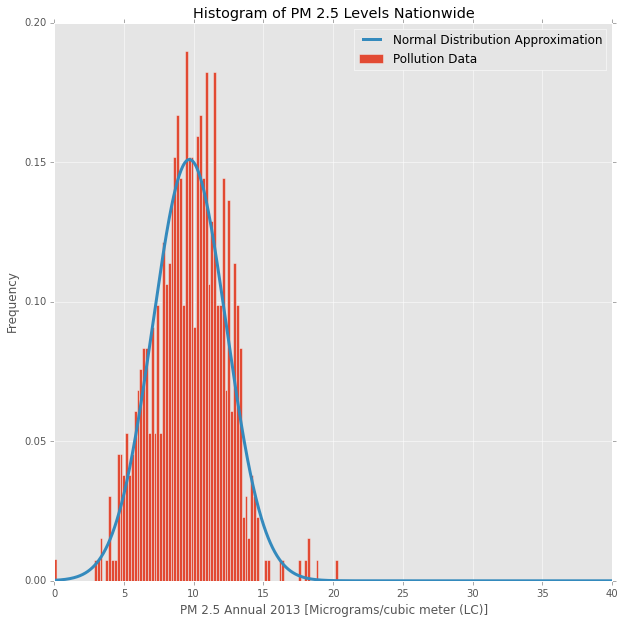

In [24]:
pl.figure(figsize=(10,10))
m, sd = stats.norm.fit(pivot_final2010['Arithmetic Mean'])
x = np.linspace(0,40,1000)
y = stats.norm.pdf(x, m, sd)

bins, hist, patches = pl.hist(pivot_final2010['Arithmetic Mean'], bins=100, normed=True, label='Pollution Data')
pl.plot(x,y, linewidth=3, label='Normal Distribution Approximation')
pl.xlabel('PM 2.5 Annual 2013 [Micrograms/cubic meter (LC)]')
pl.ylabel('Frequency')
pl.title('Histogram of PM 2.5 Levels Nationwide')
pl.legend()

2010 data fits better